In [3]:
import os
import torch
from PIL import Image
from datasets import Dataset, Features, Value, Image as DatasetImage
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, TrainingArguments, Trainer
import evaluate

c:\Users\ahmed\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


# Step 1: Load and Prepare Data
annotations_dir = r"C:\Users\ahmed\Desktop\STP\prescription-data\annotations"

if not os.path.isdir(annotations_dir):
    raise FileNotFoundError(f"Annotations folder not found: {annotations_dir}")

# Collect image-text pairs
image_files = [f for f in os.listdir(annotations_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
data = {"image": [], "text": []}

for img_file in image_files:
    img_path = os.path.join(annotations_dir, img_file)
    txt_file = img_path.replace(".png", ".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
    
    if not os.path.exists(txt_file):
        print(f"Warning: No text file found for {img_file}")
        continue
    
    try:
        # Load image
        img = Image.open(img_path).convert("RGB")
        # Read text
        with open(txt_file, "r", encoding="utf-8") as f:
            text = f.read().strip()
        data["image"].append(img)  # Store PIL image directly
        data["text"].append(text)
    except Exception as e:
        print(f"Error processing {img_file}: {e}")
        continue

if not data["image"]:
    raise FileNotFoundError("No valid image-text pairs found in annotations folder.")

# Define dataset features
features = Features({
    "image": DatasetImage(),
    "text": Value("string")
})

dataset = Dataset.from_dict(data, features=features)
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]



In [4]:
print(train_dataset.__len__())
print(eval_dataset.__len__())

2443
272


In [5]:
print(train_dataset[0]["text"])
Image._show(train_dataset[0]["image"])

ديكسا ميثازون عند اللزوم


In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id  # Typically 0 or 2
model.config.pad_token_id = processor.tokenizer.pad_token_id  # Typically 1
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id  # Fallback
if model.config.pad_token_id is None:
    model.config.pad_token_id = processor.tokenizer.eos_token_id  # Fallback to EOS if needed

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> i

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [8]:
def process_example(examples):
    # Images are already PIL objects from the dataset
    images = [img.convert("RGB") for img in examples["image"]]  # Ensure RGB format
    pixel_values = processor(images, return_tensors="pt").pixel_values.to(device)
    labels = processor.tokenizer(
        examples["text"],
        padding="max_length",
        max_length=128,
        truncation=True,
        return_tensors="pt"
    ).input_ids.to(device)
    return {"pixel_values": pixel_values, "labels": labels}

In [9]:
print(processor.tokenizer.tokenize("Paracetamol 500mg قرص واحد يومياً"))

['Par', 'acet', 'am', 'ol', 'Ġ500', 'mg', 'ĠÙ', 'Ĥ', 'Ø±', 'Ø', 'µ', 'ĠÙĪ', 'Ø§Ø', 'Ń', 'Ø¯', 'ĠÙ', 'Ĭ', 'ÙĪ', 'Ùħ', 'ÙĬ', 'Ø§', 'Ù', 'ĭ']


In [10]:
processed_train_dataset = train_dataset.map(
    process_example,
    batched=True,
    remove_columns=["image", "text"]
)
processed_eval_dataset = eval_dataset.map(
    process_example,
    batched=True,
    remove_columns=["image", "text"]
)

# Evaluation Metrics (CER)
cer_metric = evaluate.load("cer")

Map: 100%|██████████| 272/272 [00:03<00:00, 75.81 examples/s]


In [11]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=labels_str)
    return {"cer": cer}

In [12]:
class TrOCRTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(
            pixel_values=inputs["pixel_values"],
            labels=inputs["labels"]
        )
        return (outputs.loss, outputs) if return_outputs else outputs.loss

In [16]:
training_args = TrainingArguments(
    output_dir="./trocr_finetuned_khatt_medical",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    fp16=True,
    dataloader_num_workers=0,
    metric_for_best_model="cer",
    greater_is_better=False,
)

# Step 7: Initialize and Train Model
trainer = TrOCRTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_eval_dataset,
    compute_metrics=compute_metrics,
)

In [17]:
trainer.train()

Step,Training Loss
10,0.079100
20,0.064500
30,0.061000
40,0.051100
50,0.059900
60,0.054300
70,0.046100
80,0.044800
90,0.066700
100,0.073400


TrainOutput(global_step=918, training_loss=0.02529888218654267, metrics={'train_runtime': 21394.5891, 'train_samples_per_second': 0.343, 'train_steps_per_second': 0.043, 'total_flos': 5.484182164809449e+18, 'train_loss': 0.02529888218654267, 'epoch': 3.0})

In [18]:
model.save_pretrained("./trocr_finetuned_medical")
processor.save_pretrained("./trocr_finetuned_medical")

[]

In [ ]:
trainer.push_to_hub(
)


NameError: name 'trainer' is not defined

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
processor = TrOCRProcessor.from_pretrained("./trocr_finetuned_medical")
model = VisionEncoderDecoderModel.from_pretrained("./trocr_finetuned_medical")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

In [ ]:
model.push_to_hub(
    repo_id="wahdan2003/trocr-handwritten-medical"
)

processor.push_to_hub(
    repo_id="wahdan2003/trocr-handwritten-medical"
)


c:\Users\ahmed\anaconda3\envs\deeplearning\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ahmed\.cache\huggingface\hub\models--wahdan2003--trocr-handwritten-medical. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
model.safetensors: 100%|██████████| 1.34G/1.34G [1:07:45<00:00, 329kB/s]


CommitInfo(commit_url='https://huggingface.co/wahdan2003/trocr-handwritten-medical/commit/331492386a896c8284cee08de9d4a54ebb5605f9', commit_message='Upload processor', commit_description='', oid='331492386a896c8284cee08de9d4a54ebb5605f9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/wahdan2003/trocr-handwritten-medical', endpoint='https://huggingface.co', repo_type='model', repo_id='wahdan2003/trocr-handwritten-medical'), pr_revision=None, pr_num=None)

In [ ]:
inference_path = os.path.join(annotations_dir, image_files[0])  # First image as example
new_image = Image.open(inference_path).convert("RGB")
pixel_values = processor(new_image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(f"Predicted text: {generated_text}")

In [23]:
import os
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt

# Paths


# Load TrOCR processor and model
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.to(device)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

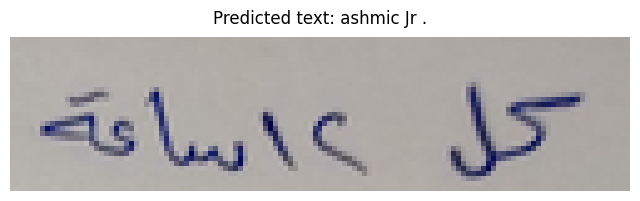

Predicted text: ashmic Jr .


In [27]:


inference_path = r"C:\Users\ahmed\Desktop\STP\prescription-data\annotations\Beauty_prescription_7_resized_box1.png"
new_image = Image.open(inference_path).convert("RGB")
pixel_values = processor(new_image, return_tensors="pt").pixel_values.to(device)


generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.imshow(new_image)
plt.axis('off')  # Hide axes
plt.title(f"Predicted text: {generated_text}", fontsize=12, pad=10)
plt.show()

# Print predicted text
print(f"Predicted text: {generated_text}")